<a href="https://colab.research.google.com/github/sanhith-lab/generative_ai_2251/blob/main/Gen_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import zipfile
import os

with zipfile.ZipFile("/content/Brain MRI Images.zip", 'r') as zip_ref:
    zip_ref.extractall()

os.listdir("Brain MRI Images")


['Train', 'Validation']

In [20]:
train_dir = 'Brain MRI Images/Train'
val_dir = 'Brain MRI Images/Validation'


In [21]:
# prompt: using cnn model for this dataset use this model model.save('my_model.keras'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Assuming train_dir and val_dir are already defined as in the previous code

IMG_WIDTH = 128
IMG_HEIGHT = 128
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 64
BUFFER_SIZE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

def build_model(num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(train_ds.class_names) # Determine the number of classes automatically
model = build_model(num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 9 # You can adjust the number of epochs
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

model.save('my_model.keras')


Found 320 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Epoch 1/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4791 - loss: 260.5904 - val_accuracy: 0.4250 - val_loss: 13.4222
Epoch 2/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4303 - loss: 7.3875 - val_accuracy: 0.5375 - val_loss: 1.0119
Epoch 3/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5359 - loss: 0.8568 - val_accuracy: 0.7000 - val_loss: 0.6313
Epoch 4/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6734 - loss: 0.6337 - val_accuracy: 0.6250 - val_loss: 0.6129
Epoch 5/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6781 - loss: 0.6019 - val_accuracy: 0.6125 - val_loss: 0.6425
Epoch 6/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7214 - loss: 0.5366 - val_accuracy: 0.8000 - val_loss: 0.4926
Epoch 7/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8591 - loss: 0.4245 - val_accuracy: 0.7250 - val_loss: 0.5828
Epoch 8/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy

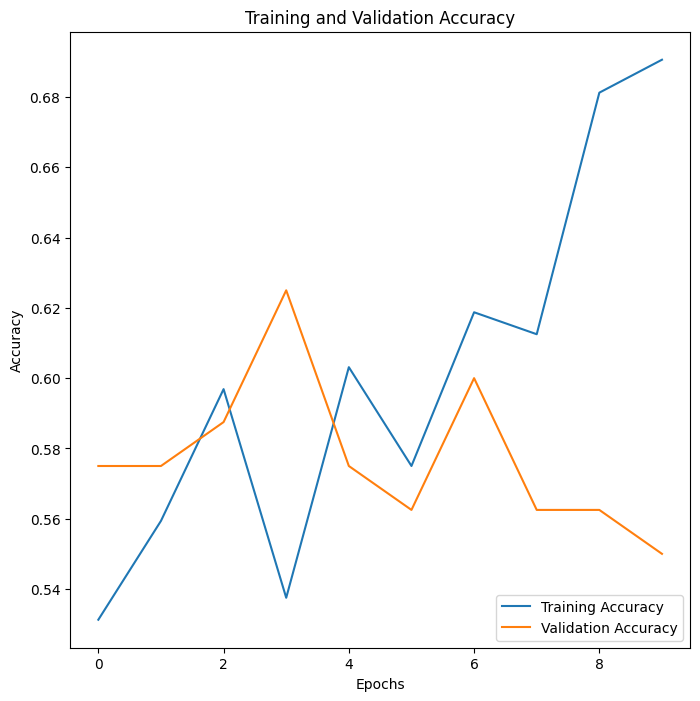

In [24]:
# prompt: represent the above accuracy in a graph format

import matplotlib.pyplot as plt

# Assuming 'history' object contains the training history from model.fit()
# history = model.fit(...)  # Replace with your actual model training

# Access accuracy values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create the plot
# epochs_range = range(epochs)  # Assuming 'epochs' is defined from the previous code
# Instead of using epochs, derive the range from the length of 'acc'
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [25]:
# prompt: use lstm

import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape

# ... (Previous code remains the same)

# LSTM Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# Reshape for LSTM
model.add(Reshape((1, -1))) # Reshape to (samples, timesteps, features) for LSTM
model.add(LSTM(64)) # LSTM layer

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# ... (Rest of the code remains the same)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# prompt: use lstm and gru

# GRU Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# Reshape for GRU
model.add(Reshape((1, -1)))  # Reshape to (samples, timesteps, features) for GRU
model.add(layers.GRU(64))  # GRU layer

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 9  # You can adjust the number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# ... (Rest of the code for plotting and saving the model remains the same)


In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
img_path = "/content/Normal (1).jpg"
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)[0][0]
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title("Prediction: " + ("Tumor Detected" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_21" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (1, 128, 128, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 128, 128, 1), dtype=float32)
  • training=False
  • mask=None

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 819ms/step - accuracy: 0.5495 - loss: 0.8170 - val_accuracy: 0.6625 - val_loss: 0.6229
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 894ms/step - accuracy: 0.6704 - loss: 0.5993 - val_accuracy: 0.7000 - val_loss: 0.5570
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 905ms/step - accuracy: 0.7499 - loss: 0.4815 - val_accuracy: 0.7000 - val_loss: 0.5586
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step - accuracy: 0.8121 - loss: 0.3917 - val_accuracy: 0.8125 - val_loss: 0.3988
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 896ms/step - accuracy: 0.9125 - loss: 0.2929 - val_accuracy: 0.7750 - val_loss: 0.4112
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 951ms/step - accuracy: 0.8512 - loss: 0.3046 - val_accuracy: 0.8125 - val_loss: 0.3734
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 752ms/step - accuracy: 0.9208 - loss: 0.2314 - val_accuracy: 0.8625 - val_loss: 0.3219
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 895ms/step - accuracy: 0.9235 - loss: 0.1418 - val_accuracy: 

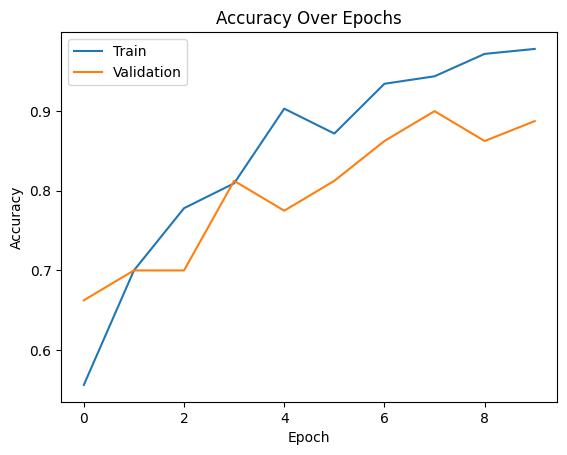

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = '/content/Brain MRI Images/Train'
val_dir = '/content/Brain MRI Images/Validation'

IMG_SIZE = 128
BATCH_SIZE = 32

# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=10)
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [1]:
# prompt: use RNN models

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import LSTM, Embedding

# Assuming 'train_data' and 'val_data' are already defined as in the previous code

# Example RNN model using LSTM
model_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=128), # Example embedding layer
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for RNN (example, adapt to your data)
# You'll need to transform your image data into sequences
# For this example, let's assume you have sequences of length 10
X_train_rnn = np.reshape(train_data[0][0], (train_data[0][0].shape[0], 10, -1))  # Reshape to (samples, timesteps, features)
y_train_rnn = train_data[0][1]
X_val_rnn = np.reshape(val_data[0][0], (val_data[0][0].shape[0], 10, -1)) # Reshape to (samples, timesteps, features)
y_val_rnn = val_data[0][1]

history_rnn = model_rnn.fit(X_train_rnn, y_train_rnn, validation_data=(X_val_rnn, y_val_rnn), epochs=10)

val_loss_rnn, val_accuracy_rnn = model_rnn.evaluate(X_val_rnn, y_val_rnn)
print(f"RNN Validation Accuracy: {val_accuracy_rnn:.2f}")

plt.plot(history_rnn.history['accuracy'], label='Train')
plt.plot(history_rnn.history['val_accuracy'], label='Validation')
plt.title('RNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'train_data' is not defined

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
preds = model.predict(val_data)
pred_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_data.classes
print(classification_report(true_labels, pred_labels, target_names=['Normal', 'Tumor']))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step
              precision    recall  f1-score   support

      Normal       0.35      0.38      0.37        34
       Tumor       0.51      0.48      0.49        46

    accuracy                           0.44        80
   macro avg       0.43      0.43      0.43        80
weighted avg       0.44      0.44      0.44        80



In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=10)
model.save("brain_tumor_cnn_model.h5")


Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 776ms/step - accuracy: 0.5974 - loss: 0.8222 - val_accuracy: 0.6750 - val_loss: 0.6683
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 950ms/step - accuracy: 0.6227 - loss: 0.6611 - val_accuracy: 0.6875 - val_loss: 0.5899
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 883ms/step - accuracy: 0.7129 - loss: 0.5690 - val_accuracy: 0.7625 - val_loss: 0.5288
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.7743 - loss: 0.4644 - val_accuracy: 0.8375 - val_loss: 0.4017
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 883ms/step - accuracy: 0.8718 - loss: 0.3130 - val_accuracy: 0.8875 - val_loss: 0.3347
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 930ms/step - accuracy: 0.9028 - loss: 0.2370 - val_accuracy: 0.9000 - val_loss: 0.2785
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.9330 - loss: 0.2240 - val_accuracy: 0.9375 - val_loss: 0.2320
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 905ms/step - accuracy: 0.9627 - loss: 0.1204 - val_accuracy: 0.8375 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


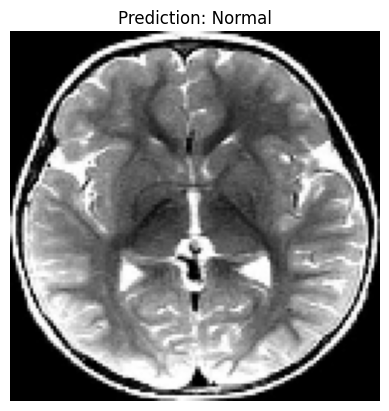

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
img_path = "/content/Normal (1).jpg"
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)[0][0]
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title("Prediction: " + ("Tumor Detected" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()